In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Basic RNNs

### Forecasting a Time Series
- Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step.
    - This is called a **time series.**
- In the first two examples there is a single value per time step, so these are **univariate time series**, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a **multivariate time series.**
- A typical task is to predict future values, which is called **forecasting.**
- Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. 
    - This is called **imputation.**

#### Generate the Dataset
For simplicity, we are using a time series generated by the generate_time_series() function, shown here:

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

- This function creates as many time series as requested (via the batch_size argument), each of length n_steps, and there is just one value per time step in each series (i.e., all series are univariate).
- The function returns a NumPy array of shape [batch size, time steps, 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.
### NOTE
- **When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [batch size, time steps, dimensionality], where dimensionality is 1 for univariate time series and more for multivariate time series.**

Now let’s create a training set, a validation set, and a test set using this function:

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

- X_train contains 7,000 time series (i.e., its shape is [7000, 50, 1]), while X_valid contains 2,000 (from the 7,000th time series to the 8,999th) and X_test contains 1,000 (from the 9,000 to the 9,999 ). 
- Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1]).

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

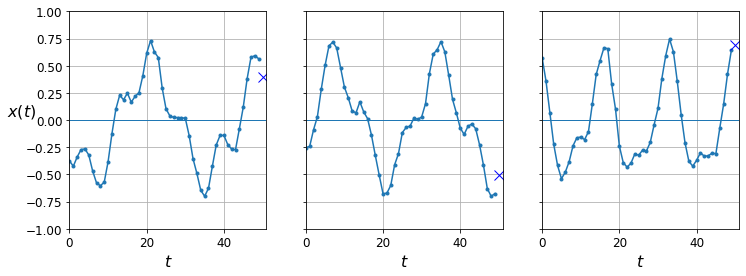

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Baseline Metrics
- Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. 
- For example, the simplest approach is to **predict the last value in each series.**
    - This is called **naive forecasting**, and it is sometimes surprisingly difficult to outperform.
    - In this case, it gives us a mean squared error of about 0.020:

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

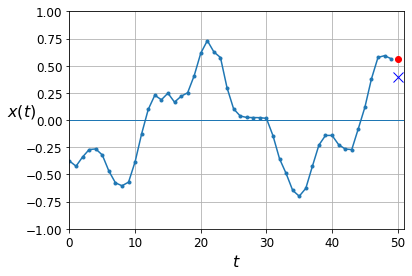

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

- Another simple approach is to use a **fully connected network.** 
- **Since it expects a flat list of features for each input, we need to add a Flatten layer.**
- Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168087616562843

- If we compile this model using the MSE loss and the default Adam optimizer, then fit it on the training set for 20 epochs and evaluate it on the validation set, we get an MSE of about 0.004. 
- **That’s much better than the naive approach!**

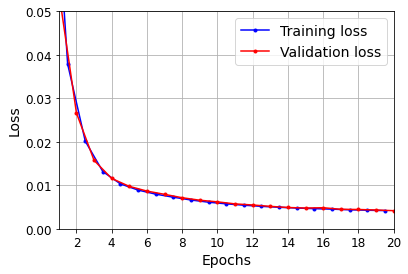

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

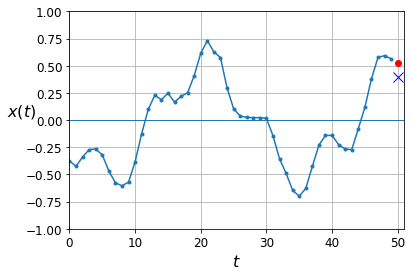

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Implementing a Simple RNN
Let’s see if we can beat that with a simple RNN:

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

- That’s really the simplest RNN you can build. It just contains a single layer, with a single neuron.
- We do not need to specify the length of the input sequences (unlike in the previous model), since a **recurrent neural network can process any number of time steps (this is why we set the first input dimension to None).**
- By default, the SimpleRNN layer uses the **hyperbolic tangent activation function.** How it works: 
    - the initial state $h_init$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_0$.
    - The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, $y_0$.
    - In a simple RNN, this output is also the new state $h_0$.
    - This new state is passed to the same recurrent neuron along with the next input value, $x_1$ , and the process is repeated until the last time step.
    - Then the layer just outputs the last value, $y_49$.

All of this is performed simultaneously for every time series.
#### NOTE
**By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set return_sequences=True.**

In [13]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 19ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0117 - val_lo

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0109


0.010881561785936356

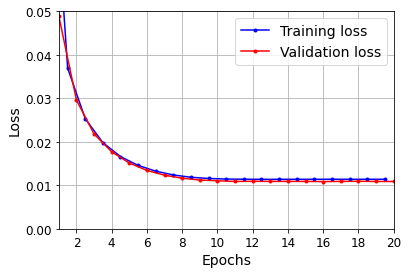

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

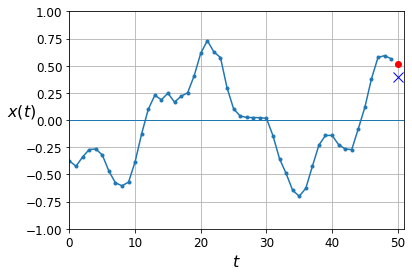

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

- If you compile, fit, and evaluate this model (just like earlier, we train for 20 epochs using Adam), you will find that its MSE reaches only 0.010, so it is better than the naive approach but it does not beat a simple linear model.
- Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters).
- In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. 
    - In this simple RNN, that’s a total of just three parameters.

**Apparently our simple RNN was too simple to get good performance. So let’s try to add more recurrent layers!**

## Deep RNNs
- It is quite common to stack multiple layers of cells, this gives you a **deep RNN.**
- Implementing a deep RNN with tf.keras is quite simple: just stack recurrent layers. 
- In this example, we use three SimpleRNN layers (but we could add any other type of recurrent layer, such as an LSTM layer or a GRU layer).

#### WARNING
- **Make sure to set return_sequences=True for all recurrent layers (except the last one, if you only care about the last output).** 
- **If you don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.**

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 14s 46ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 10s 43ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0035 - v

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0029


0.0029105644207447767

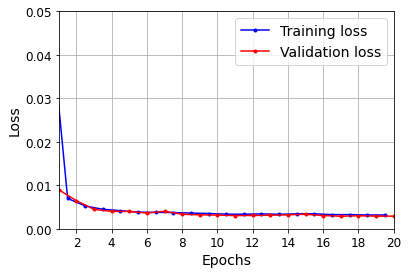

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

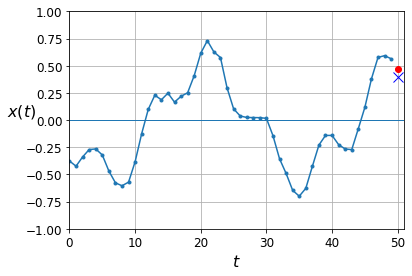

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

If you compile, fit, and evaluate this model, you will find that it reaches an
MSE of 0.003. We finally managed to beat the linear model!
- Note that the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step.
    - However, having a single unit means that the hidden state is just a single number.
    - That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much.
- **Moreover, since a SimpleRNN layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1.**
    - **But what if you want to use another activation function? For both these reasons, it might be preferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want.**
        - **If you make this change, also make sure to remove return_sequences=True from the second (now last) recurrent layer:**

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 35ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0029 - val_l

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 15ms/step - loss: 0.0026


0.0026236246339976788

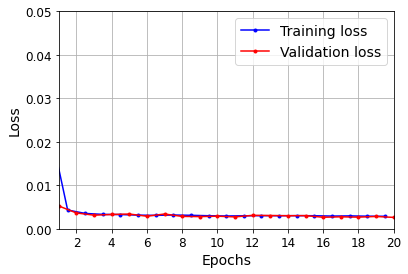

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

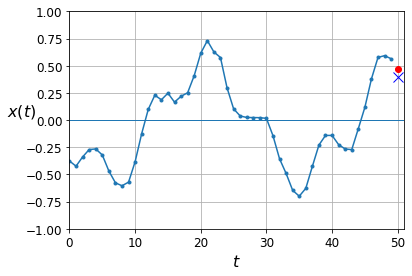

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

- If you train this model, you will see that it converges faster and performs just as well. 
    - Plus, you could change the output activation function if you wanted.

### Forecasting Several Time Steps Ahead
- So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets to be the value 10 steps ahead instead of 1 step ahead). 

But what if we want to predict the next 10 values?
- **The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on, as in the following code:**

In [25]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [26]:
Y_pred.shape

(1, 10, 1)

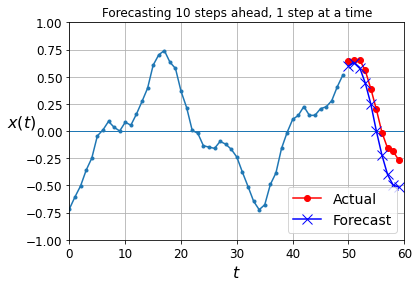

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.title("Forecasting 10 steps ahead, 1 step at a time")
plt.show()

- If you evaluate this approach on the validation set, you will find an MSE of about 0.029. 
    - This is much higher than the previous models, but it’s also a much harder task, so the comparison doesn’t mean much. 
    - It’s much more meaningful to compare this performance with naive predictions (just forecasting that the time series will remain constant for 10 time steps) or with a simple linear model. 
- The naive approach is terrible (it gives an MSE of about 0.223), but the linear model gives an MSE of about 0.0188: it’s much better than using our RNN to forecast the future one step at a time, and also much faster to train and run.
- Still, if you only want to forecast a few time steps ahead, on more complex tasks, this approach may work well.

- **The second option is to train an RNN to predict all 10 next values at once.**
- We can still use a sequence-to-vector model, but it will output 10 valuesinstead of 1. 
    - However, we first need to change the targets to be vectors containing the next 10 values:

In [28]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [29]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [30]:
Y_pred.shape

(2000, 10)

In [31]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510837

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [32]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0222

Now let's create an RNN that predicts all 10 next values at once:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 31ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0118 - va

In [35]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

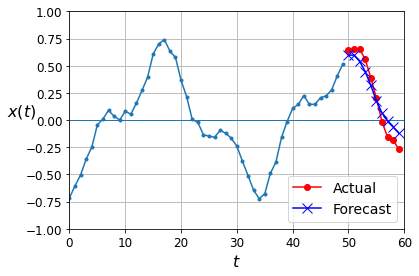

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [37]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [38]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

### NOTE
- It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between X_train and Y_train). 
- Isn’t that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a **causal model.**
***

- **To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step.**
    - Keras offers a **TimeDistributed layer** for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence.
- It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from [batch size, time steps, input dimensions] to [batch size × time steps, input dimensions]; in this example, **the number of input dimensions is 20 because the previous SimpleRNN layer has 20 units)**, then it runs the Dense layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from [batch size × time steps, output dimensions] to [batch size, time steps, output dimensions]; **in this example the number of output dimensions is 10, since the Dense layer has 10 units)**. Here is the updated model:

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 31ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0367 - val_last_time_step_mse: 0.0266
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0339 - last_time_step_mse: 0.0228 - val_loss: 0.0374 - val_last_time_step_mse: 0.0287
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0310 - last_time_step_mse: 0.0206 - val_loss: 0.0279 - val_last_time_step_mse: 0.0171
Epoch 5/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0278 - last_time_step_mse: 0.0162 - val_loss: 0.0255 - val_last_time_step_mse: 0.0134
Epoch 6/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0258 - last_time_step_mse: 0.0134 - val_loss: 0.0223 - val_last_time_step_mse: 0.0088
Epoch 7/20
219/219 [=

- **The Dense layer actually supports sequences as inputs** (and even higherdimensional inputs): it handles them just like TimeDistributed(Dense(…)), **meaning it is applied to the last input dimension only (independently across all time steps).**
- Thus, we could replace the last layer with just Dense(10). For the sake of clarity, however, we will keep using TimeDistributed(Dense(10)) because **it makes it clear that the Dense layer is applied independently at each time step and that the model will output a sequence, not just a single vector.**
- All outputs are needed during training, but **only the output at the last time step is useful for predictions and for evaluation.** 
    - So although we rely on the MSE over all the outputs for training, we have used a custom metric for evaluation, to only compute the MSE over the output at the last time step.

In [40]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

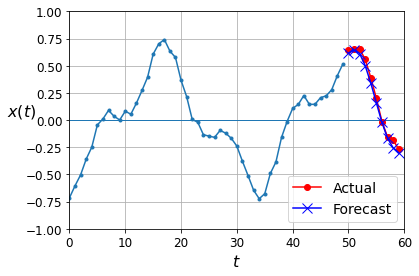

In [41]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Simple RNNs can be quite good at forecasting time series or handling other kinds of sequences, but they do not perform as well on long time series or sequences.** Let’s discuss why and see what we can do about it.

## Handling Long Sequences
- To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem: it may take forever to train, or training may be unstable.
- Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence. Let’s look at both these problems, starting with the unstable gradients problem.

### Fighting the Unstable Gradients Problem

### Deep RNN with Batch Normalization
- Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. 
- However, nonsaturating activation functions (e.g., ReLU) **may not help as much here; in fact, they may actually lead the RNN to be even more unstable during training.**
- Why? Well, suppose Gradient Descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode and a nonsaturating activation function does not prevent that.
- You can reduce this risk by using a smaller learning rate, but you can also simply use a saturating activation function like the hyperbolic tangent (this explains why it is the default). 
    - In much the same way, the gradients themselves can explode. 
    - If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use Gradient Clipping.
- **Moreover, Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets.**
    - In fact, you cannot use it between time steps, only between recurrent layers.
- To be more precise, it is technically possible to add a BN layer to a memory cell (as we will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). 
    - However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state.
- In practice, this does not yield good results, as was demonstrated by César Laurent et al. in a 2015 paper: the authors found that BN was slightly beneficial only when it was applied to the inputs, not to the hidden states.
    - **In other words, it was slightly better than nothing when applied between recurrent layers** , but not within recurrent layers (i.e., horizontally). 
- In Keras this can be done simply by adding a BatchNormalization layer before each recurrent layer, but don’t expect too much from it.


In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 14s 44ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [

### Deep RNNs with Layer Normalization
- Another form of normalization often works better with RNNs: Layer Normalization. 
    - This idea was introduced by Jimmy Lei Ba et al. in a 2016 paper: it is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension.
- One advantage is that it can **compute the required statistics on the fly, at each time step, independently for each instance.**
    - This also means that it behaves the same way during training and testing (as opposed to BN), and **it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set**.
- Like BN, Layer Normalization learns a scale and an offset parameter for each input. 
    - **In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.**
- Let’s use tf.keras to implement Layer Normalization within a simple memory cell. 
    - For this, we need to define a custom memory cell. 
    - It is just like a regular layer, except its call() method takes two arguments: the inputs at the current time step and the hidden states from the previous time step.
        - Note that the states argument is a list containing one or more tensors.
- In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short-term state, as we will see shortly).
- A cell must also have a state_size attribute and an output_size attribute. 
    - In a simple RNN, both are simply equal to the number of units.

**The following code implements a custom memory cell which will behave like a SimpleRNNCell, except it will also apply Layer Normalization at each time step:**

In [43]:
from tensorflow.keras.layers import LayerNormalization

In [44]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

- The code is quite straightforward. Our LNSimpleRNNCell class inherits from the keras.layers.Layer class, just like any custom layer.
- To use this custom cell, all we need to do is create a keras.layers.RNN layer, passing it a cell instance:

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 22s 77ms/step - loss: 0.2886 - last_time_step_mse: 0.2837 - val_loss: 0.0741 - val_last_time_step_mse: 0.0690
Epoch 2/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0686 - last_time_step_mse: 0.0585 - val_loss: 0.0572 - val_last_time_step_mse: 0.0430
Epoch 3/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0558 - last_time_step_mse: 0.0426 - val_loss: 0.0499 - val_last_time_step_mse: 0.0369
Epoch 4/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0484 - last_time_step_mse: 0.0348 - val_loss: 0.0439 - val_last_time_step_mse: 0.0299
Epoch 5/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0432 - last_time_step_mse: 0.0292 - val_loss: 0.0431 - val_last_time_step_mse: 0.0279
Epoch 6/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0410 - last_time_step_mse: 0.0271 - val_loss: 0.0372 - val_last_time_step_mse: 0.0251
Epoch 7/20
219/2

- Similarly, you could create a custom cell to apply dropout between each time step. 
- But there’s a simpler way: all recurrent layers (except for keras.layers.RNN) and all cells provided by Keras have a dropout hyperparameter and a recurrent_dropout hyperparameter: the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step).
- No need to create a custom cell to apply dropout at each time step in an RNN.
- With these techniques, you can alleviate the unstable gradients problem and train an RNN much more efficiently.

Now let’s look at how to deal with the short-term memory problem.

### Tackling the Short-Term Memory Problem
- Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. 
- After a while, the RNN’s state contains virtually no trace of the first inputs. 
    - This can be a showstopper. 
    - Imagine Dory the fish trying to translate a long sentence; by the time she’s finished reading it, she has no clue how it started. 
- To tackle this problem, various types of cells with long-term memory have been introduced. 
    - They have proven so successful that the basic cells are not used much anymore. 
- Let’s first look at the most popular of these long-term memory cells: the LSTM cell.

### LSTM cells
- The Long Short-Term Memory (LSTM) cell was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber and gradually improved over the years by several researchers, such as Alex Graves, Haşim Sak, and Wojciech Zaremba. 
- If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data. 

**In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:**

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 28s 97ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 21s 96ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 17s 80ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/2

In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 20ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788683116436005, 0.00856079813092947]

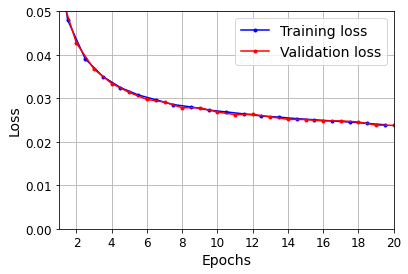

In [48]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [49]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

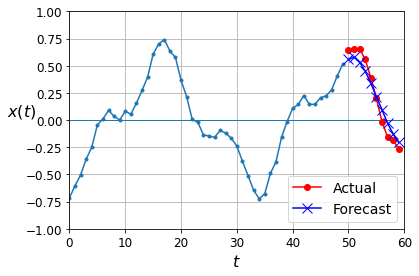

In [50]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

So how does an LSTM cell work? Its architecture is shown in Figure 15-9.
- If you don’t look at what’s inside the box, the LSTM cell looks exactly like a regular cell, except that **its state is split into two vectors: h and c (“c” stands for “cell”).** 
    - You can think of **h as the short-term state** and **c as the long-term state.**

<img src="15-9.png">

- Now let’s open the box! The key idea is that **the network can learn what to store in the long-term state, what to throw away, and what to read from it.**
- As the long-term state c(t-1) traverses the network from left to right, you can see that it first goes through a forget gate, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an input gate).
    - The result c(t) is sent straight out, without any further transformation.
- So, at each time step, some memories are dropped and some memories are added.
    - Moreover, after the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered by the output gate.
    - This produces the short-term state h(t)(which is equal to the cell’s output for this time step, y(t)).
***
- **In short, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed.** 
    - This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

There are many other variants of the LSTM cell. One particularly popular variant is the **GRU cell**, which we will look at now.

### GRU cells
- The Gated Recurrent Unit (GRU) cell (see Figure 15-10) was proposed by Kyunghyun Cho et al. in a 2014 paper.
<img src="15-10.png">

- The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well (which explains its growing popularity).

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 24s 84ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/2

In [52]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 16ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.01026280876249075]

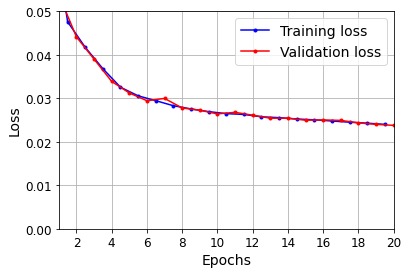

In [53]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [54]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

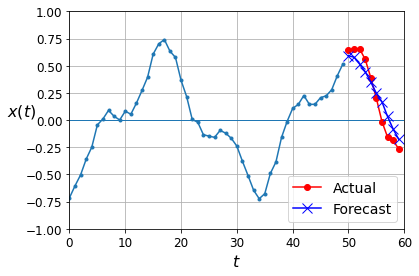

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

- LSTM and GRU cells are one of the main reasons behind the success of RNNs. 
    - Yet while they can tackle much longer sequences than simple RNNs, they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences. 
- One way to solve this is to shorten the input sequences, for example using 1D convolutional layers.

### Using 1D convolutional layers to process sequences
- a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). 
- Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel.
    - Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). 
    - If you use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently you can view this output as a single 10-dimensional sequence.
- This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers).
    - If you use a 1D convolutional layer with a **stride of 1 and "same" padding**, then **the output sequence will have the same length as the input sequence.**
    - But if you use **"valid" padding or a stride greater than 1**, then **the output sequence will be shorter than the input sequence**, so make sure you adjust the targets accordingly.
- For example, the following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2.
    - The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details.
- By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns.
    - Note that we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2:

1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 18s 51ms/step - loss: 0.0908 - last_time_step_mse: 0.0845 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0437 - last_time_step_mse: 0.0357 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0356 - last_time_step_mse: 0.0282 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0293 - last_time_step_mse: 0.0201 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0256 - last_time_step_mse: 0.0152 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0239 - last_time_step_mse: 0.0129 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219

- If you train and evaluate this model, you will find that **it is the best model so far.** 
- The convolutional layer really helps. 
- In fact, **it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely!**

### WaveNet
- In a 2016 paper, Aaron van den Oord and other DeepMind researchers introduced an architecture called WaveNet.
- **They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer:** the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on(see Figure 15-11).
    - **This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns.**
    - Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

<img src="15-11.png">

- In the WaveNet paper, the authors actually stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, …, 256, 512, then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, …, 256, 512), then again another identical group of 10 layers. 
- They justified this architecture by pointing out that **a single stack of 10 convolutional layers with these dilation rates will act like a super-efficient convolutional layer with a kernel of size 1,024** (except way faster, more powerful, and using significantly fewer parameters), which is why they stacked 3 such blocks.
- They also left-padded the input sequences with a number of zeros equal to the dilation rate before every layer, to preserve the same sequence length throughout the network. 

Here is how to implement a simplified WaveNet to tackle the same sequences as earlier:

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in(1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1)) #output layer
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 22ms/step - loss: 0.0981 - last_time_step_mse: 0.0891 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0340 - last_time_step_mse: 0.0212 - val_loss: 0.0294 - val_last_time_step_mse: 0.0167
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0291 - last_time_step_mse: 0.0163 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0265 - last_time_step_mse: 0.0141 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0251 - last_time_step_mse: 0.0129 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0243 - last_time_step_mse: 0.0122 - val_loss: 0.0233 - val_last_time_step_mse: 0.0107
Epoch 7/20
219/219 [==

- This **Sequential model starts with an explicit input layer** (this is simpler than trying to set input_shape only on the first layer), then **continues with a 1D convolutional layer using "causal" padding:** this ensures that the convolutional layer does not peek into the future when making predictions (**it is equivalent to padding the inputs with the right amount of zeros on the left and using "valid" padding**).
- We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8.
- Finally, we add **the output layer: a convolutional layer with 10 filters of size 1 and without any activation function**.
- Thanks to the padding layers, every convolutional layer outputs a sequence of the same length as the input sequences, so the targets we use during training can be the full sequences: no need to crop them or downsample them.
***

The last two models offer the best performance so far in forecasting our time series!
- **In the WaveNet paper, the authors achieved state-of-the-art performance on various audio tasks (hence the name of the architecture), including text-to-speech tasks, producing incredibly realistic voices across several languages.**
    - **They also used the model to generate music, one audio sample at a time.**
    - **This feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps—even LSTMs and GRUs cannot handle such long sequences.**
    
***